# Creating a basketball mini map using homography transformations

Author Stephan Janssen (sja@devoxx.com)

See also related [article on LinkedIn](https://www.linkedin.com/pulse/journey-towards-creating-basketball-mini-map-stephan-janssen/) and result on [YouTube](https://www.youtube.com/watch?v=tpavRDeDlTI).

We still need to identify the players per team which can be achieved using colour detection, that's not too difficult.

Improvements or suggestions are always welcome!

# Install detectron2

In [1]:
# install dependencies
#from google.colab import drive
#drive.mount('/content/drive')


!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /opt/anaconda3/envs/py38/lib/python3.8/site-packages (1.9.1)
Requirement already up-to-date: torchvision in /opt/anaconda3/envs/py38/lib/python3.8/site-packages (0.10.1)
Requirement already up-to-date: cython in /opt/anaconda3/envs/py38/lib/python3.8/site-packages (0.29.24)
  Cloning https://github.com/facebookresearch/fvcore to /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-3socj_ld
  Running command git clone -q https://github.com/facebookresearch/fvcore /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-3socj_ld
  Cloning https://github.com/cocodataset/cocoapi.git to /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-wfen419l
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-wfen419l
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=64745 sha256=e2c40fa3db7b6a74600

'1.9.1'

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-1ut1ysfx
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-req-build-1ut1ysfx
Processing /Users/gauravmohan/Library/Caches/pip/wheels/e7/77/b2/6f38b5bea571cd8f4689f91a7c1ed2eaecb2c2ce17f9945b17/pycocotools-2.0.2-cp38-cp38-macosx_10_9_x86_64.whl
  Created wheel for detectron2: filename=detectron2-0.5-cp38-cp38-macosx_10_9_x86_64.whl size=832002 sha256=5bdcb60c6c47c27b24261a69c776528541c8eca29a334aa38c97c4d688a89f44
  Stored in directory: /private/var/folders/yc/mbn2xm6j69dfhf0x0vq1wj840000gq/T/pip-ephem-wheel-cache-vlvwkzn7/wheels/19/ac/65/e48e5e4ec2702274d927c5a6efb75709b24014371d3bb778f2
Successfully built detectron2
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstal

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect

# Some basic setup

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

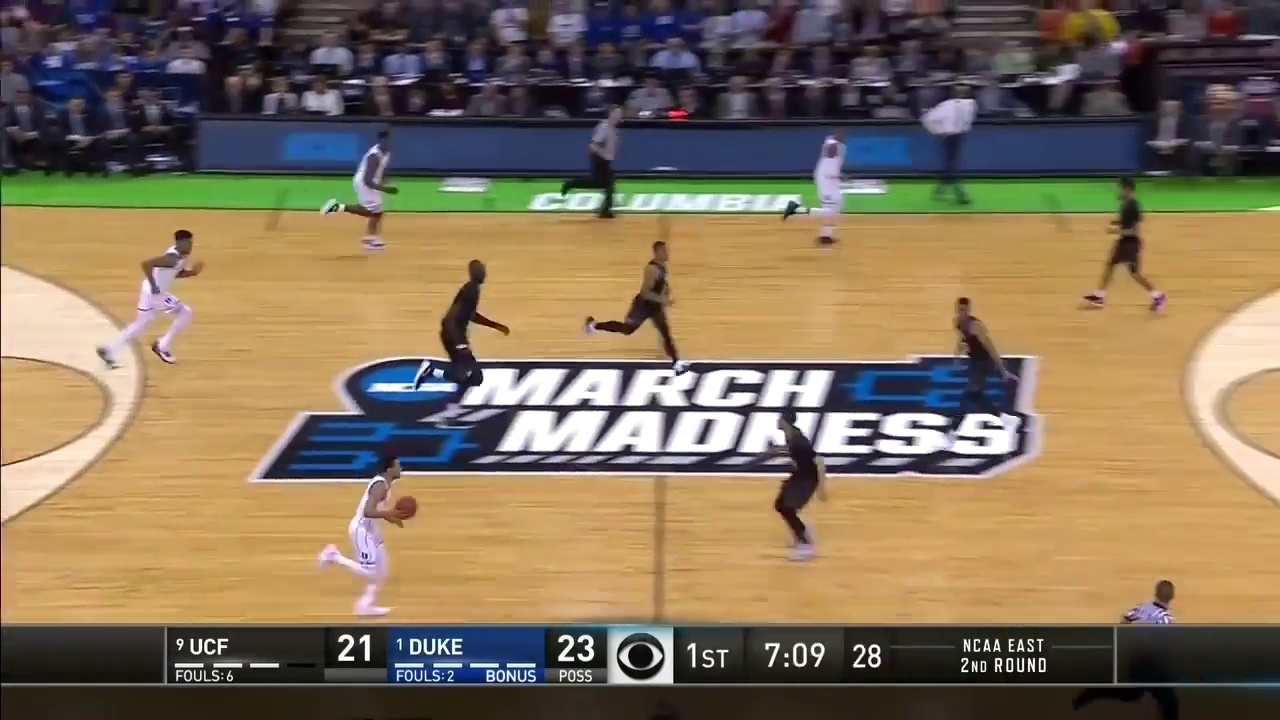

In [4]:
#!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/3DVideoFrame.jpg -O input.jpg
im_l = cv2.imread("/Users/gauravmohan/Documents/Basketball_Homography/college_left_half.jpg",  cv2.IMREAD_COLOR)
im_r = cv2.imread("/Users/gauravmohan/Documents/Basketball_Homography/college_right_half.jpg", cv2.IMREAD_COLOR)
im_m = cv2.imread("/Users/gauravmohan/Documents/Basketball_Homography/college_middle.jpg", cv2.IMREAD_COLOR)
cv2_imshow(im_m)

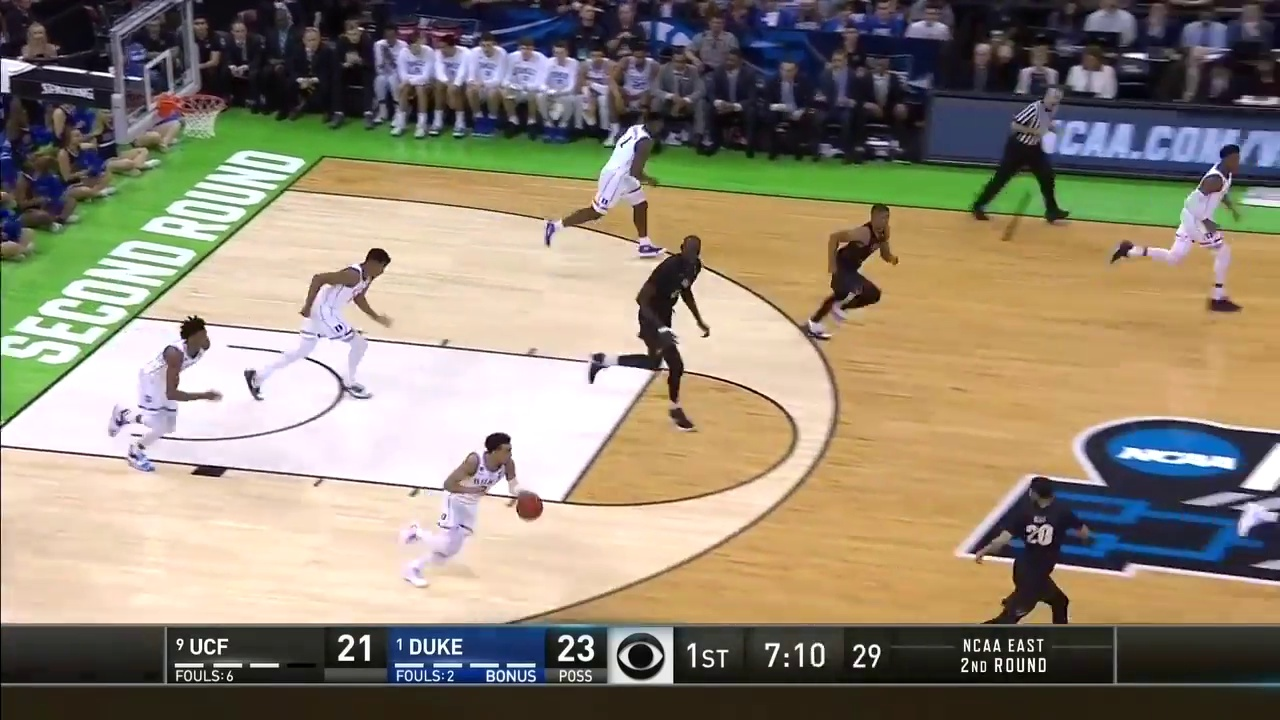

In [5]:
cv2_imshow(im_l)

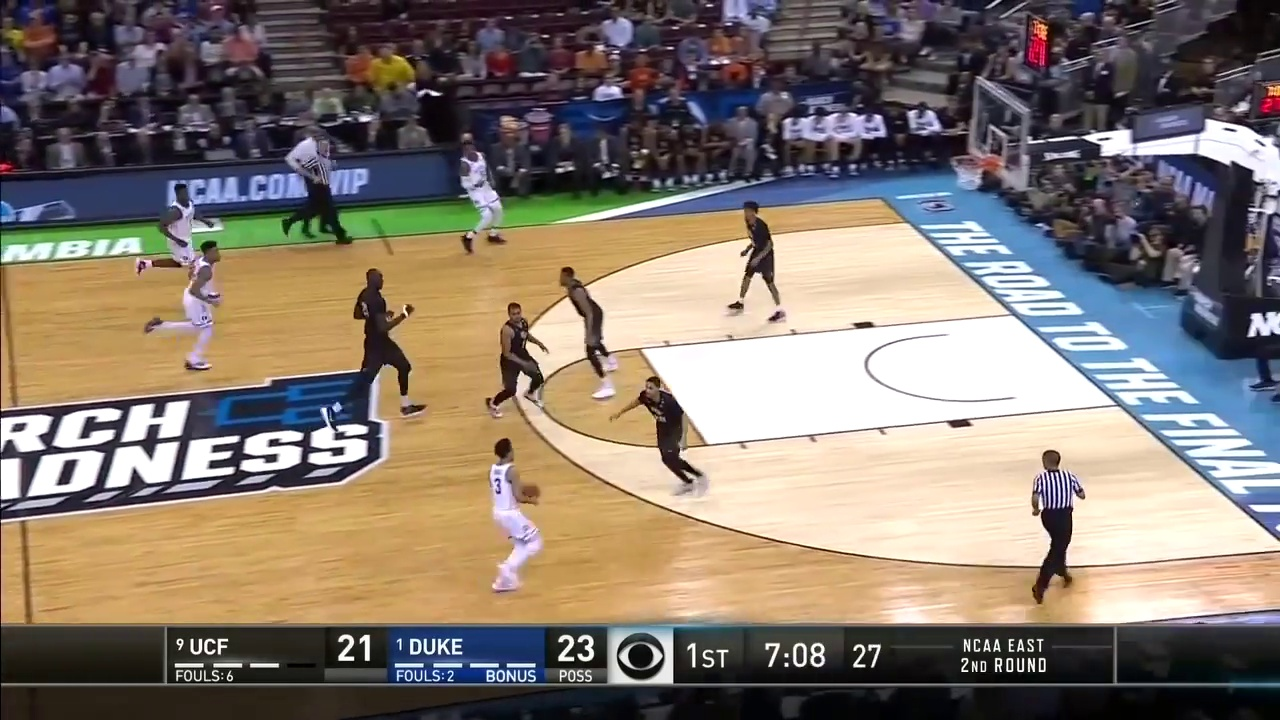

In [6]:
cv2_imshow(im_r)

In [7]:
uci_color = [255,0,0]
away_color = [0,0,255]

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [8]:
cfg = get_cfg()

cfg.merge_from_file("./detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)

players_output = predictor(im_l)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [9]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
instances = players_output["instances"]
print(instances)
pred_boxes = instances.get("pred_boxes")
pred_classes = instances.get("pred_classes")
print(pred_boxes)
print(pred_classes)

Instances(num_instances=31, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 802.6025,  203.8850,  898.6840,  337.9269],
        [1108.5553,  143.1604, 1246.8170,  308.8334],
        [ 250.4002,  249.0119,  387.6382,  402.0813],
        [ 599.7579,  231.6440,  711.0402,  422.1310],
        [ 963.8367,  476.2519, 1090.9794,  630.0784],
        [ 971.7807,   74.5273, 1070.6711,  235.6214],
        [ 117.0219,  314.3972,  219.8308,  479.1780],
        [1062.9351,   41.3374, 1118.8888,   97.5181],
        [ 549.4876,  111.5902,  667.5853,  254.6699],
        [ 396.7802,  431.4607,  533.7689,  590.7830],
        [ 430.3394,   28.3012,  475.5177,  138.3280],
        [ 534.8245,   38.9397,  582.3371,  139.6402],
        [ 368.3417,   20.8339,  409.4656,  129.2455],
        [ 390.0749,   30.1316,  435.4137,  138.1310],
        [ 500.1729,   36.5502,  548.3262,  138.7319],
        [ 466.2526,   28.8455,  509.3924,  134.6459],
        [ 276.2402,   25.9309,  343.4727,  123

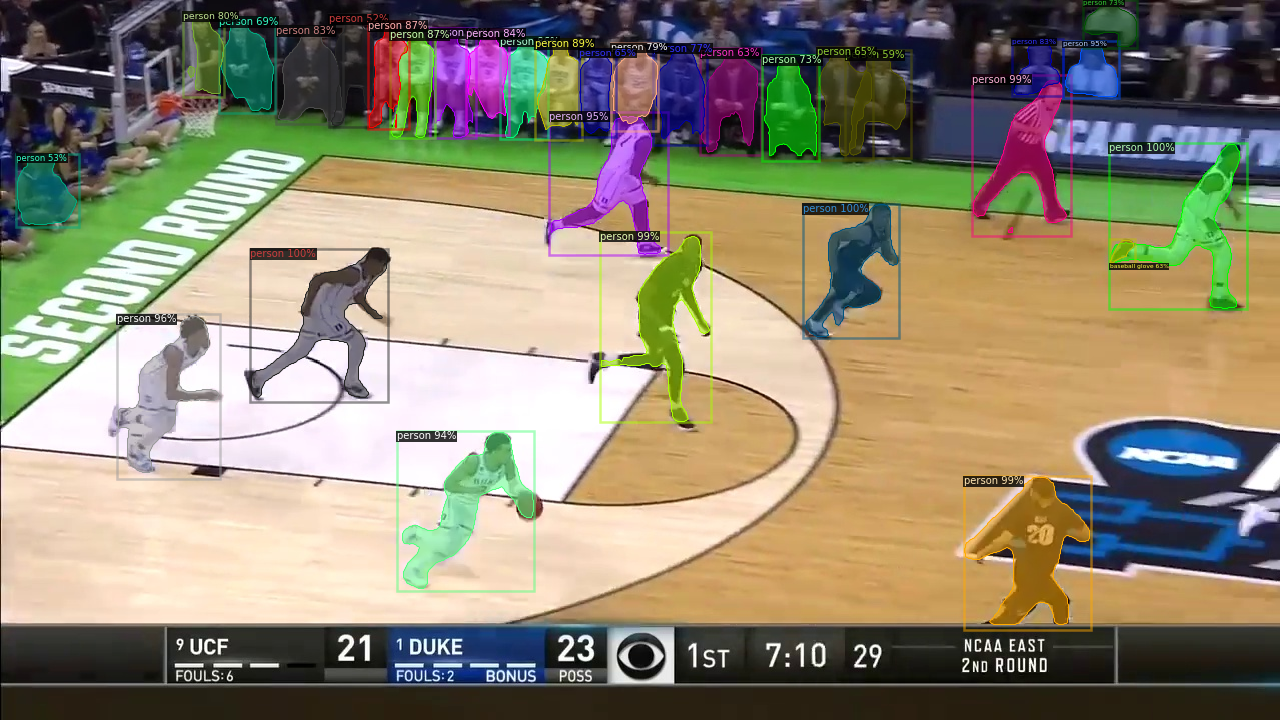

In [10]:
from detectron2.utils.visualizer import Visualizer

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im_l[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
v = v.draw_instance_predictions(players_output["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

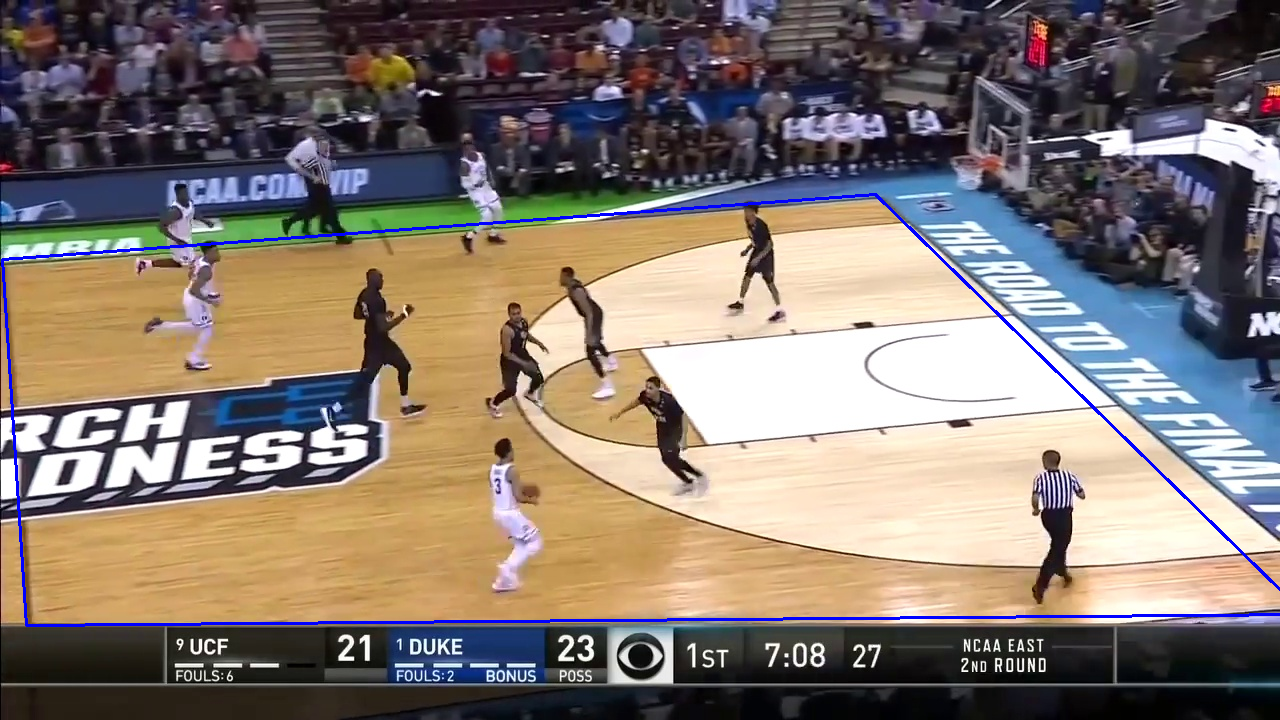

In [37]:
import numpy as np
# Four corners of the 3D court 
# Start top-left corner and go anti-clock wise
src_midpts = np.array([
        [1173,208], #TR
        [1190,621], #BR
        [143,621], #BL
        [173,201] #TL
    ])

src_rightpts = np.array([
        [875,194], #TR
        [1305,614], #BR
        [26,625], #BL
        [2,259] #TL
    ]) 

src_leftpts = np.array([
        [1276,233], #TR
        [1276,624], #BR
        [3,580], #BL
        [320,154] #TL
    ])  

im_poly = im_r.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_rightpts], isClosed=True, color=[255,0,0], thickness=2)

cv2_imshow(im_poly)

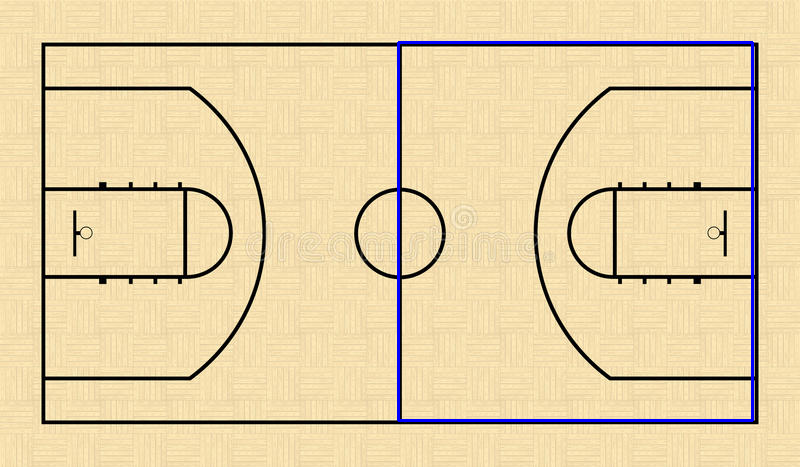

In [38]:
img_dst = cv2.imread('/Users/gauravmohan/Documents/Basketball_Homography/full-court.jpeg')

# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_rightpts = np.array([
      [398,  420],  # LEFT BOTTOM
      [752,  420],  # RIGHT BOTTOM
      [752, 42],   # TOP RIGHT  (4 o'clock)
      [398,  42]   # TOP LEFT (7 o'clock)
    ]) 

dst_leftpts= np.array([
      [40,420],  # LEFT BOTTOM
      [398,  420],  # RIGHT BOTTOM
      [398,  42],   # TOP RIGHT  (4 o'clock)
      [40,42] # TOP LEFT (7 o'clock)
    ]) 

dst_midpts = np.array([
      [265,  420],  # LEFT BOTTOM
      [534,  420],  # RIGHT BOTTOM
      [534, 43],   # TOP RIGHT  (4 o'clock)
      [265,  43]   # TOP LEFT (7 o'clock)
    ])




cv2.polylines(img_dst, [dst_rightpts], isClosed=True, color=[255,0,0], thickness=2)
cv2_imshow(img_dst)

In [13]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates

    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform

    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points

    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)

    tpts = np.zeros(pts.shape)
    for i in range(pts.shape[1]):
        u = H[0][0]*pts[0][i] + H[0][1]*pts[1][i] + H[0][2]
        v = H[1][0]*pts[0][i] + H[1][1]*pts[1][i] + H[1][2]
        w = H[2][0]*pts[0][i] + H[2][1]*pts[1][i] + H[2][2]

        x_prime = u/w
        y_prime = v/w

        tpts[0][i] = x_prime
        tpts[1][i] = y_prime
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])

    return tpts

In [14]:
def homographyLeftTransform(im,showResult=False):
    # Calculate Homography
    h, status = cv2.findHomography(src_leftpts, dst_leftpts)
    img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
    if showResult:
        cv2_imshow(img_out)
    return h
# Try out
#img_out = homographyLeftTransform(im, True)

In [15]:
def homographyRightTransform(im,showResult=False):
    # Calculate Homography
    h, status = cv2.findHomography(src_rightpts, dst_rightpts)
    img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
    if showResult:
        cv2_imshow(img_out)
    return h
# Try out
#img_out = homographyTransform(im, True)

In [16]:
def homographyMidTransform(im,showResult=False):
    # Calculate Homography
    h, status = cv2.findHomography(src_midpts, dst_midpts)
    img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
    if showResult:
        cv2_imshow(img_out)
    return h
# Try out
#img_out = homographyMidTransform(im, True)

In [17]:
from shapely.geometry import Point, Polygon
import os
import shutil


def create_images(im,box_coords):
    dir = os.listdir('/Users/gauravmohan/Documents/Basketball_Homography/images') 
    if len(dir) != 0:
        shutil.rmtree('/Users/gauravmohan/Documents/Basketball_Homography/images')
        print('Successful Removal')
        os.mkdir('/Users/gauravmohan/Documents/Basketball_Homography/images')
        print('Successful Creation')
        image = im
        copy = image.copy()

        ROI_number = 0
        for k,v in box_coords.items():
            x,y,w,h = int(v[0]),int(v[1]),int(v[2]),int(v[3])
            ROI = image[y:h, x:w]
            cv2.imwrite(os.path.join('/Users/gauravmohan/Documents/Basketball_Homography/images','ROI_{}.png'.format(k)), ROI)
            cv2.rectangle(copy,(x,y),(w,h),(36,255,12),2)
        print('Directory Newly Populated')
        
    else:  
        image = im
        copy = image.copy()

        ROI_number = 0
        for k,v in box_coords.items():
            x,y,w,h = int(v[0]),int(v[1]),int(v[2]),int(v[3])
            ROI = image[y:h, x:w]
            cv2.imwrite(os.path.join('/Users/gauravmohan/Documents/Basketball_Homography/images','ROI_{}.png'.format(k)), ROI)
            cv2.rectangle(copy,(x,y),(w,h),(36,255,12),2)
        print('Directory Populated')
        cv2_imshow(copy)
    

def drawPlayers(im, pred_boxes, h, src, showResult=False):
    color = [255, 0, 0]   
    thickness = 8
    radius = 8
    temp = []
    new_pts = []
    player_coord_init = {}
    i = 0
    for box in pred_boxes:
        if pred_classes[i] == 0 or 32: 
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            #print(box[0])
            xc = x1 + int((x2 - x1)/2)
            player_pos1 = (xc - 1, y2)
            player_pos2 = (xc + 1, y2 + 1)
            
        if src == 'right':
            court = Polygon(src_rightpts)
        elif src == 'left':
            court = Polygon(src_leftpts)
        else:
            court = Polygon(src_midpts)



      # Draw only players that are within the basketball court
        if Point(player_pos1).within(court):
            if showResult:
                player_posx = np.array([xc])
                player_posy = np.array([y2])
                player_pos = np.array([player_posx,player_posy])
                new_player_pos = apply_homography(h,player_pos)
                if pred_classes[i] == 32:
                    print('Found Ball')
                    temp.append((pred_boxes[i],new_player_pos,'ball'))
                else:
                    temp.append((pred_boxes[i],new_player_pos))
                #playerpos_new = homographyTransform(im, False,temp[])
                i+=1
                #print("[% 3d, % 3d]" %(xc, y2))
            cv2.rectangle(im, player_pos1, player_pos2, color, thickness)
    #create_images(im,player_coord_init)

    
    
    for i in temp:
        for element in i[0]:
            element = element.tolist()
            x,y=i[1][0],i[1][1]
            index = ((int(x[0]),int(y[0])))
            try:
                full = str(index) + '-' + str(i[2])
                player_coord_init[full] = element
            except:
                player_coord_init[index] = element
    #print(player_coord_init)
    create_images(im,player_coord_init)
    if showResult:
        cv2_imshow(im)
#h = homographyMidTransform(im, False)
#drawPlayers(im, pred_boxes, h, True)

In [18]:
!pip install webcolors
import cv2
import numpy as np
import argparse
import ntpath
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import csv
import webcolors
import pandas as pd
from PIL import Image
from collections import defaultdict,Counter
# construct the argument parse and parse the arguments
def create_rgb_csv():
    path = "/Users/gauravmohan/Documents/Basketball_Homography/images"
    f = []
    for filename in os.listdir(path):
        rgb_final = []
        image_file = filename
        if image_file.endswith('.png'):
            fname = image_file.split('.png')[0]
            img = Image.open(path+'/'+str(image_file))
            #cv2_imshow(img)
            fig = plt.figure(figsize=(15, 10))
            plt.axis('off')

            #print(img)
            try:
                img = img.convert('RGB')
            except:
                break
            x,y = img.size
            try:
                rgb_pixel_value1= img.getpixel((x/2,y/2))
                rgb_pixel_value2= img.getpixel((x/2+3,y/2))
                rgb_pixel_value3= img.getpixel((x/2-3,y/2))
                rgb_pixel_value4= img.getpixel((x/2,y/2+3))
                rgb_pixel_value5= img.getpixel((x/2,y/2-3))
                rgb_final.append(rgb_pixel_value1)
                rgb_final.append(rgb_pixel_value2)
                rgb_final.append(rgb_pixel_value3)
                rgb_final.append(rgb_pixel_value4)
                rgb_final.append(rgb_pixel_value5)
                f.append([fname, rgb_final]) 
            except:
                pass
        else:
            pass
    return f
'''
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css21_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
'''
def get_colour_name(requested_colour):
    if requested_colour[0] > 200 and requested_colour[1] > 180 and requested_colour[2] > 140:
        closest_color = uci_color
    else:
        closest_color = away_color
    
    return webcolors.rgb_to_name(closest_color)


def get_info():
    final = {}
    f = create_rgb_csv()
    r_temp = 0
    g_temp = 0
    b_temp = 0
    for i in f:
        print(i[0])
        if 'ball' in i[0]:
            closest_name = webcolors.rgb_to_name([255,165,0])
            index = i[0].split('-')[0]
            final[index] = closest_name
        else:
            for v in i[1]:
                r_temp += v[0]
                g_temp += v[1]
                b_temp += v[2]
            r = (int)(r_temp/5)
            g = (int)(g_temp/5)
            b = (int)(b_temp/5)
            final_color = ((r,g,b))
            closest_name = get_colour_name(final_color)
            final[i[0]] = closest_name
                #print("Actual colour name:", actual_name, ", closest colour name:", closest_name)
                #init[i[0]].append(closest_name)

    return final

        # save_color_bar(bar, image_file)
# plt.axis("off")
# plt.imshow(bar)
# plt.show()

In [19]:
#!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/2DCourt1920x1080.jpg -O court.jpg

In [20]:
def getPlayersMask(im):
  lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
  upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
  mask = cv2.inRange(im, lower_range, upper_range)     # Create a mask with range
  result = cv2.bitwise_and(im, img_out, mask = mask)   # Performing bitwise and operation with mask in img variable
  cv2_imshow(result)                              

  return cv2.inRange(result, lower_range, upper_range)  
  
# Try out  
#mask = getPlayersMask(img_out)    
#cv2_imshow(mask)

In [21]:
def drawPlayersOnCourt(im, coord, color, radius=10):
    center_coordinates = (coord[0], coord[1])
    cv2.circle(im, center_coordinates, radius, color, thickness=-1) 
    return im

Now lets create a mini-map based on a 30 seconds basketball game.

In [22]:
#!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/mini-map-game-input.mp4 -O video.mp4


In [23]:
# Draft method to draw lines between history player positions to show trail
def drawCoordinateLines(result, pts, currentFrame, player):
  
  for i in np.arange(1, len(pts)):
    
    # if either of the tracked points are None, ignore them
    if pts[i - 1] is None or pts[i] is None:
      continue

    thickness = int(np.sqrt(30 / float(i + 1)) * 2.5)
    print("player=%s" %player)
    x1 = pts[i - 1][0][0]
    x2 = pts[i - 1][0][1]
    print("x1=%d, x2=%d" %(x1, x2))
    y1 = pts[i][0][0]
    y2 = pts[i][0][1]
    print("y1=%d, y2=%d" %(y1, y2))
    print(" ---------------------- ")
    cv2.line(result, (x1, x2), (y1, y2), red_color, thickness)

  return result

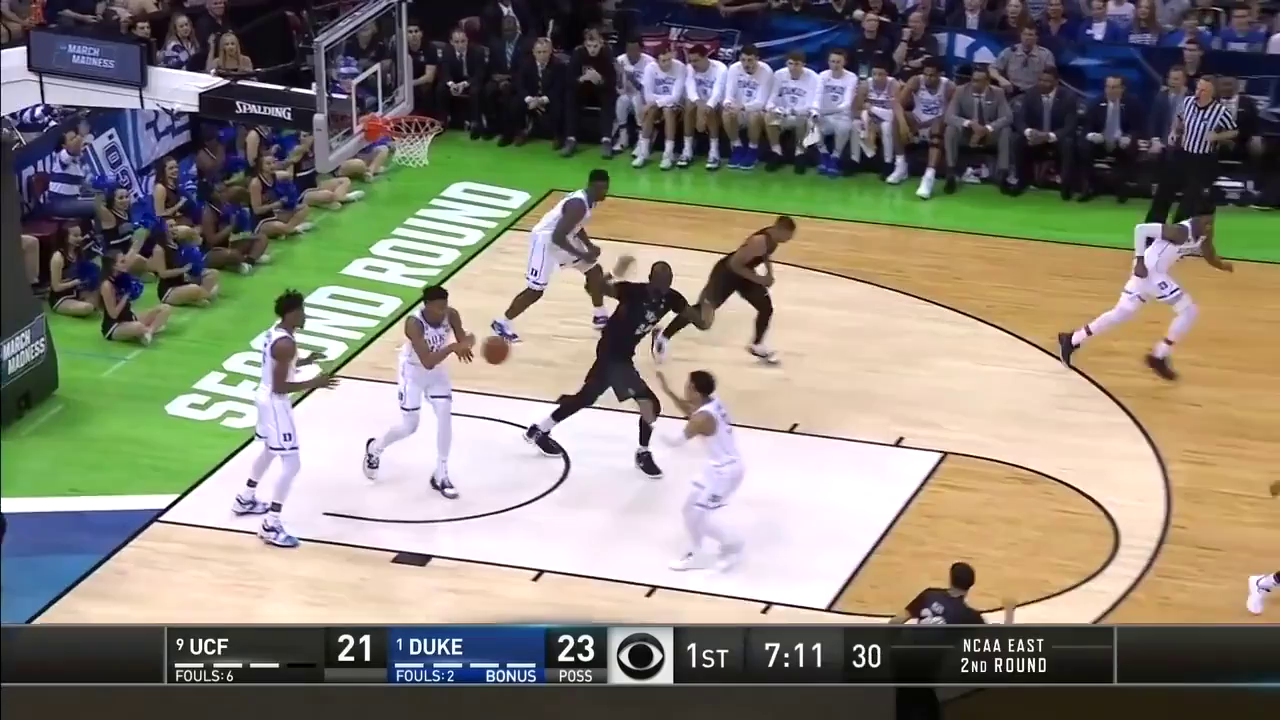

In [ ]:
import time
import progressbar
from time import sleep
from collections import deque
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask
import imutils



import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color




# Playing video from file:
cap = cv2.VideoCapture('/Users/gauravmohan/Documents/Basketball_Homography/videos/input_vid2.mp4')
start = time.time()

currentFrame = 0
totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
grabbed = True
    # Capture frame-by-frame
# When everything done, release the capture

writer = None
bar = progressbar.ProgressBar(maxval=totalFrames, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()
count = 0
court_img = cv2.imread('/Users/gauravmohan/Documents/Basketball_Homography/full-court.jpeg')

# loop over frames from the video file stream (207)
while grabbed:
    grabbed, frame = cap.read()
    cv2_imshow(frame)
    #cv2.imwrite("frames/frame%d.jpg" % (currentFrame+1), frame) 
    
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter("output-vid.mp4", fourcc, 24, (court_img.shape[1], court_img.shape[0]), True)

    if grabbed:
        # print(currentFrame)

        # Get player positions
        outputs = predictor(frame)  
        instances = outputs["instances"].to("cpu")
        boxes = instances.get("pred_boxes")
        court = court_img.copy()
        
        
        # Draw players on video frame
        cv2_imshow(frame)
        
        if currentFrame < 45:
            h = homographyLeftTransform(frame, False)
            drawPlayers(frame, boxes,h,'left', True)  
        elif currentFrame >= 45 and currentFrame <= 95:
            h = homographyMidTransform(frame, False)
            drawPlayers(frame, boxes,h,'mid', True)
        elif currentFrame > 95:
            h = homographyRightTransform(frame, False)
            drawPlayers(frame, boxes,h,'right', True)
        

        ### 
        # cv2_imshow(img_out)

        #mask = getPlayersMask(img_out)

        #cv2_imshow(mask)

        # Get the contours from the players "dots" so we can reduce the coordinates
        # to the number of players on the court.

        cnts = get_info()

        if cnts is not None:      
          for k,v in cnts.items():
            k = k[4:]
            print(k)
            res = tuple((int(num) for num in k.replace('(', '').replace(')', '').split(', ')))
            result = drawPlayersOnCourt(court,res,webcolors.name_to_rgb(v))

        writer.write(result)
        currentFrame += 1
        bar.update(currentFrame)
    if currentFrame >= totalFrames:
        grabbed = False

# cv2_imshow(result)
    
writer.release()
cap.release()
bar.finish()
cv2.destroyAllWindows()
end = time.time()
elap = (end - start)
print("[INFO] process took {:.4f} seconds".format(elap))

print("Video created")
